# Controller design

In [Part 2](workflow02.md) of this series we implemented a first-principles physics model for our DC gearmotor system and calibrated it using experimental data.
The next step of our workflow is _controller design_, where we will develop an algorithm for driving the motor output shaft quickly and efficiently to a reference position.

Again, because the goal of this series is to step through the development workflow and not to build a sophisticated motor controller, we'll keep the controller simple to highlight the process.
Specifically, we'll use a proportional-integral (PI) controller, a simple and robust solution for reference tracking.

In [ ]:
# ruff: noqa: N802, N803, N806, N815, N816
import os
import pickle

import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
import control

import archimedes as arc
from archimedes.experimental.signal import IIRFilter
from archimedes.docs.utils import (
    extract_py_function, extract_py_class, display_text
)

from motor import (
    RAD_PER_COUNT,
    SUPPLY_VOLTAGE,
    motor_ode,
    MotorParams,
    MotorInputs,
    plant_step,
    quad_count,
    hil_dt,
)

THEME = os.environ.get("ARCHIMEDES_THEME", "dark")
arc.theme.set_theme(THEME)

# Load calibrated parameters from Part 2
with open("data/motor_params.pkl", "rb") as f:
    params = MotorParams(**pickle.load(f))

## Dynamics model

In the previous part of this series we implemented an idealized DC gearmotor model:

$$
\begin{align*}
L \frac{di}{dt} &= V - iR - k_\mathcal{E} \omega \\
J \frac{d\omega}{dt} &= k_\mathcal{\tau} i - b \omega
\end{align*}
$$

and calibrated it with step response data.
This is a linear time-invariant model that we can apply classical control analysis to.

In this case it would be easy enough to write the model by hand, but since we have automatic differentiation at our disposal and we know the model is linear, it will be even easier to automatically calculate the Jacobians and determine the linear state-space form:

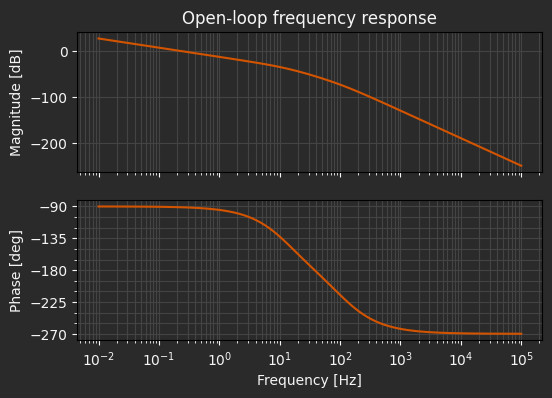

In [ ]:
x0 = np.array([0.0, 0.0, 0.0])
u0 = np.array([0.0])

# Extract state-space model using autodiff
A = arc.jac(motor_ode, argnums=1)(0, x0, u0, params)
B = arc.jac(motor_ode, argnums=2)(0, x0, u0, params)
C = np.array([[0.0, 1.0, 0.0]])  # Output is position
D = np.array([[0.0]])  # No direct feedthrough

# Transfer function from voltage to position
num, den = signal.ss2tf(A, B, C, D)
G = control.tf(num[0], den, name="plant")

fig, ax = plt.subplots(2, 1, figsize=(6, 4), sharex=True)
control.bode_plot(G, dB=True, Hz=True, omega=np.logspace(-2, 5, 100) * 2*np.pi, ax=ax)
ax[0].set_title("Open-loop frequency response")
plt.show()

## PI controller

A proportional-integral controller is a feedback control law of the form:

$$
u(t) = k_p e(t) + k_i \int_0^t e(t) ~ dt,
$$

where $e(t) = r(t) - y(t)$ is the error between the output $y(t)$ and the reference or set point $r(t)$.

In transfer function form,

$$
\frac{u(s)}{e(s)} = \frac{k_p s + k_i}{s}.
$$

With this and the plant model, we can quickly tune the gains to find a good combination.

In [ ]:
kp = 10.42
ki = 3.0

C = control.tf(np.array([kp, ki]), np.array([1, 0]), name="controller")
C

TransferFunction(array([10.42,  3.  ]), array([1, 0]))

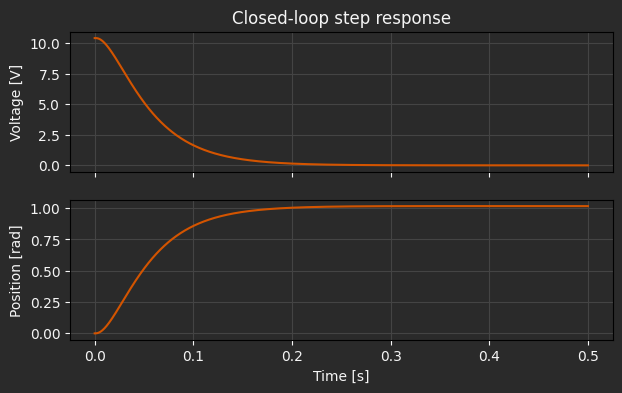

In [ ]:
H_ur = C / (1 + G * C)  # Transfer function from reference -> control input
H_yr = (G * C) / (1 + G * C)  # Transfer function from reference -> output

t = np.linspace(0, 0.5, 1000)
yr_resp = control.step_response(H_yr, t)
ur_resp = control.step_response(H_ur, t)

fig, ax = plt.subplots(2, 1, figsize=(7, 4), sharex=True)

ax[0].set_title("Closed-loop step response")

ax[0].plot(t, ur_resp.outputs)
ax[0].grid()
ax[0].set_ylabel("Voltage [V]")
ax[1].plot(t, yr_resp.outputs)
ax[1].grid()
ax[1].set_ylabel("Position [rad]")

ax[-1].set_xlabel("Time [s]")

plt.show()

Recall that in Part 2 we found that the mechanical time constant was around 100 ms, about the same as we see here for rise time.
For our purposes, we'll take a response time that matches the natural system dynamics to be sufficient.

It's also worth checking Nyquist stability, which confirms that the PI will be a robust closed-loop controller:

Gain margin: 33.18 dB at 37.75 Hz
Phase margin: 76.32 deg at 2.62 Hz


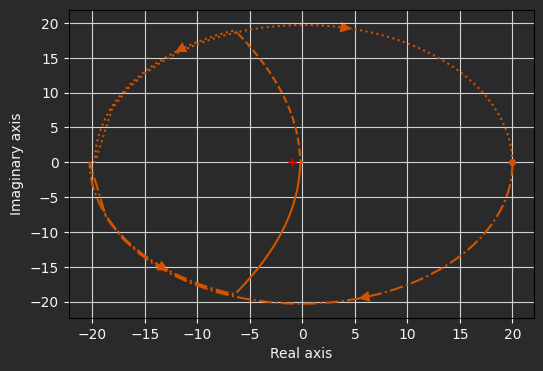

In [ ]:
gm, pm, wcg, wcp = control.margin(C * G)
print(f"Gain margin: {20*np.log10(gm):.2f} dB at {wcg/(2*np.pi):.2f} Hz")
print(f"Phase margin: {pm:.2f} deg at {wcp/(2*np.pi):.2f} Hz")

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
control.nyquist_plot(C * G, ax=ax)
plt.show()

## Full controller implementation

Now we have a theoretical control law tuned and ready to go.
All that's left is to transform to discrete time and implement the rest of the digital control logic (saturation, direction switching, etc.).

The discretization is easy since we have a transfer function representation of our controller.
We can simply call `sample` to apply a zero-order hold discretization to the transfer function and then implement the discretized form as an infinite impulse response (IIR) digital filter.

In [ ]:
# Convert transfer function to discrete-time IIR filter
dt = hil_dt
C_pid = C.sample(dt)  # Position error -> Voltage command
pid_ctrl = IIRFilter(C_pid.num[0][0], C_pid.den[0][0])

C_pid

TransferFunction(array([ 10.42  , -10.4197]), array([ 1., -1.]), 0.0001)

One decision point at this stage is which calculations and conversions are part of the "control algorithm" and which are "embedded implementation details".
This is likely project-dependent, but here we will consider anything that depends on the details of the microcontroller or the circuit configuration to be embedded implementation details.
Ideally, working with "embedded implementation details" wouldn't require much knowledge of control theory, while working with the "control algorithm" wouldn't require much knowledge of electrical engineering.

In this case, the "control algorithm" implementation won't handle scaling from 12-bit A/D output values to corresponding voltages and won't handle voltage divider calculations.
It will simply take the measured position, the reference position, and any internal controller state, and will output a PWM duty cycle (float, (0-1) scale) and two logic values corresponding to the motor direction (`INA`, `INB`).

We'll use the same control algorithm implementation in two ways:

1. In simulation, to verify the full control logic works as expected (see below)
2. To auto-generate C code for deployment to the STM32 board

Using the same "source of truth" for both simulation and deployment means there's less that can go wrong when updating the controller logic, and makes it easier to implement smooth workflows that progress from quick "sanity checks" (in simulation) to more expensive "reality checks" (on hardware).

In [ ]:
# Determine motor direction logic values
# This is basic H-bridge logic; see the VNH5019 datasheet for details
def motor_logic(d) -> tuple[bool, bool]:
    INA, INB = np.where(d > 0, np.array([1, 0]), np.array([0, 1]))
    return INA, INB


# Full controller implementation: this is what we'll use to generate the C code
@arc.compile(name="controller", return_names=("state_new", "pwm_duty", "INA", "INB"))
def controller_step(state, pos, pos_ref) -> tuple[IIRFilter.State, float, int, int]:

    # Calculate commanded current as output of position control
    e = pos_ref - pos
    state_new, V = pid_ctrl(state, e)

    # Approximate motor voltage with linear model
    u = V / SUPPLY_VOLTAGE

    # Determine motor direction logic values
    INA, INB = motor_logic(u)

    # Set to PWM duty cycle (always 0-1)
    pwm_duty = np.clip(abs(u), 0, 1)

    return state_new, pwm_duty, INA, INB


# Check that the controller works without errors
x0 = pid_ctrl.x0
controller_step(x0, 0.0, 1.0)

[IIRFilter.State(u_prev=array([1., 0.]), y_prev=array([10.42])),
 array(0.86833333),
 array(1),
 array(0)]

## Simulating the controller

So far we have a calibrated physics model and a tuned PI feedback law implemented as a digital control algorithm.
We've evaluated the control law using a continuous-time simulation with the physics model (the step response above).
For more complex systems and controllers, we might want to repeat this with more varied scenarios, but let's say we're confident in the performance based on this idealized simulation configuration.

The next step in our end-to-end workflow is to implement a more detailed discrete-time plant model that fully emulates the behavior of the physical system, including sensor and electronics models.
In our case this will include not only the DC gearmotor physics, but also the H-bridge behavior, quadrature encoder, current sense output, and voltage dividers.

The reason for this extra fidelity is the additional validation that we are handling all of these details correctly.
For instance, we can check that the controller is handling reversals of direction properly.
Is it continuing to output a positive PWM duty cycle, but inverting the `INA`, `INB` logical outputs?

This follows the incremental validation philosophy of this end-to-end workflow.
If we stop with the continuous-time simulation we've only checked the theoretical performance of the controller, but if we skip straight to this higher-fidelity version we couldn't be sure if issues were related to the feedback control law, its time discretization, or other aspects of the digital logic.

In addition, this higher-fidelity plant model is exactly what we will use as the real-time simulation for HIL testing in the next part of this tutorial.
What we're simulating here are the raw voltages seen by the controller, so if we can match reality well enough we should have a "digital twin" of the physical system ready to go for HIL.

We don't need to go into depth with these additional models of the plant behavior; they're not especially complicated, but it doesn't add much value for our purposes.
Below is the full plant model as implemented in `motor.py`, with `motor_dyn` the same discretized plant model we used for system identification and constants like `CS_V_PER_AMP` defined based on the electronic circuit and datasheet specifications.

In [ ]:
extract_py_class("motor.py", "MotorInputs")
extract_py_class("motor.py", "MotorOutputs")
extract_py_function("motor.py", "encoder")
extract_py_function("motor.py", "motor_dir")
extract_py_function("motor.py", "plant_step")

```python
@struct.pytree_node
class MotorInputs:
    pwm_duty: float  # PWM duty cycle (0-1)
    ENA: bool
    ENB: bool
    INA: bool
    INB: bool
```

```python
class MotorOutputs(NamedTuple):
    ENCA: int
    ENCB: int
    V_CS: float
    VOUTA: float
    VOUTB: float
```

```python
@arc.compile(static_argnames="PPR")
def encoder(pos: float, PPR: int) -> tuple[int, int]:
    # Convert position to encoder counts
    counts = np.fmod((pos / (2 * np.pi)) * PPR / 4, PPR / 4)

    # Generate quadrature signals
    ENCA = np.fmod(np.floor(counts * 4) + 1, 4) < 2
    ENCB = np.fmod(np.floor(counts * 4), 4) < 2

    return ENCA, ENCB
```

```python
@arc.compile
def motor_dir(INA, INB, ENA, ENB):
    d = (INA + (1 - INB)) - (INB + (1 - INA))

    # Disable if either of ENA or ENB are low
    return ENA * ENB * (d / 2)
```

```python
@arc.compile(name="plant", return_names=("state_new", "outputs"))
def plant_step(
    t,
    state: np.ndarray,
    inputs: MotorInputs,
    params: MotorParams,
) -> tuple[np.ndarray, MotorOutputs]:
    # Determine motor direction
    d = motor_dir(inputs.INA, inputs.INB, inputs.ENA, inputs.ENB)
    pwm_duty = np.clip(inputs.pwm_duty, 0.0, 1.0)
    V_motor = d * pwm_duty * SUPPLY_VOLTAGE

    # Motor dynamics model (discretized)
    u = (V_motor,)
    state = motor_dyn(t, state, u, params)

    I_motor, pos, vel = state

    # Encoder emulation
    PPR = ENC_PPR * GEAR_RATIO
    ENCA, ENCB = encoder(pos, PPR)

    # H-bridge output voltages
    VOUTA = np.where(d >= 0, V_motor * VOUT_SCALE, 0.0)
    VOUTB = np.where(d < 0, -V_motor * VOUT_SCALE, 0.0)

    # Current sense voltage
    V_CS = abs(I_motor) * CS_V_PER_AMP

    outputs = MotorOutputs(
        VOUTA=VOUTA,
        VOUTB=VOUTB,
        V_CS=V_CS,
        ENCA=ENCA,
        ENCB=ENCB,
    )

    return state, outputs
```

One last simulation detail is how we treat the encoder output.
The STM32 has built-in quadrature pulse counting with a hardware timer, so all we need to do in the embedded implementation is retrieve the current count at every sample and update our position estimate, handling wraparound and integer under/overflow as needed.

Hence, one option we have is to "cheat" a little and just pass the true position to the controller.
After all, the logic for position estimation isn't in scope for the control algorithm, since it's mainly handled by the microcontroller.

But if we want to check that the encoder emulation is working correctly (a good sanity check before we move onto HIL testing), we could also apply our own pulse counting:

In [ ]:
extract_py_function("motor.py", "quad_count")

```python
@arc.compile
def quad_count(A, B, count, prev_A, prev_B):
    rising_A = np.logical_and(A, np.logical_not(prev_A))
    count += rising_A * np.where(B, -1, 1)  # CCW

    falling_A = np.logical_and(np.logical_not(A), prev_A)
    count += falling_A * np.where(B, 1, -1)  # CW

    rising_B = np.logical_and(B, np.logical_not(prev_B))
    count += rising_B * np.where(A, 1, -1)  # CW

    falling_B = np.logical_and(np.logical_not(B), prev_B)
    count += falling_B * np.where(A, -1, 1)  # CCW

    return count
```

To run the simulation we just have to match up the inputs and outputs of the plant model and controller and loop over a control sequence.

In [ ]:
tf = 0.5
ts = np.arange(0, tf, hil_dt)
pwm_duty = np.zeros_like(ts)
I_motor = np.zeros_like(ts)
pos = np.zeros_like(ts)
vel = np.zeros_like(ts)

pos_cmd = np.ones_like(ts)  # Command position
pos_cmd[ts > tf / 2] = 0.0  # Reverse direction halfway through

x_phys = np.zeros(3)  # Initial state: [I_motor, pos, vel]
x_ctrl = x0

inputs = MotorInputs(
    pwm_duty=pwm_duty[0],  # PWM duty cycle (0-1)
    ENA=1,
    ENB=1,
    INA=1,
    INB=0,
)

enc_counts = 0
ENCA, ENCB = 0, 0  # Initial encoder signals
for i in range(len(ts)):
    # Step the plant model
    x_phys, y = plant_step(0.0, x_phys, inputs, params)
    
    # Record the full state for analysis
    I_motor[i], pos[i], vel[i] = x_phys

    # Update the encoder counts based on the new position
    enc_counts = quad_count(y.ENCA, y.ENCB, enc_counts, ENCA, ENCB)
    ENCA, ENCB = y.ENCA, y.ENCB
    pos_est = enc_counts * RAD_PER_COUNT

    if i < len(ts) - 1:
        # Step the controller
        x_ctrl, pwm_duty[i+1], INA, INB = controller_step(x_ctrl, pos_est, pos_cmd[i])
        inputs = inputs.replace(pwm_duty=pwm_duty[i+1], INA=INA, INB=INB)


Text(0.5, 0, 'Time [s]')

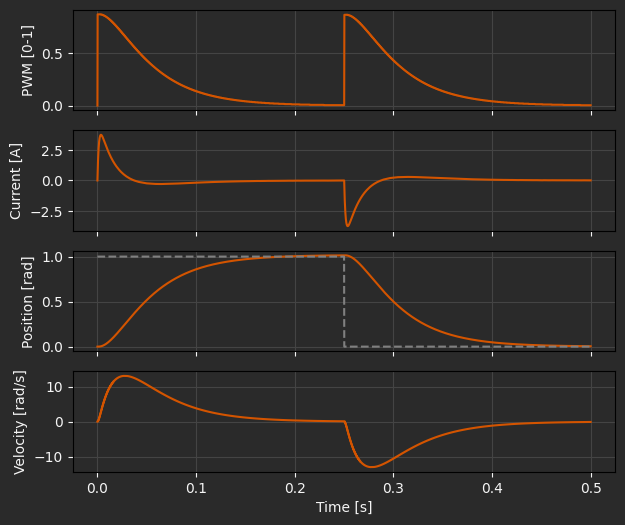

In [ ]:
fig, ax = plt.subplots(4, 1, figsize=(7, 6), sharex=True)
ax[0].plot(ts, pwm_duty)
ax[0].grid()
ax[0].set_ylabel("PWM [0-1]")

ax[1].plot(ts, I_motor)
ax[1].grid()
ax[1].set_ylabel("Current [A]")

ax[2].plot(ts, pos)
ax[2].plot(ts, pos_cmd, linestyle='--', color='gray', label="Command")
ax[2].grid()
ax[2].set_ylabel("Position [rad]")

ax[3].step(ts, vel)
ax[3].grid()
ax[3].set_ylabel("Velocity [rad/s]")

ax[-1].set_xlabel("Time [s]")

So far so good!
The response to the step change in position closely follows the theoretical behavior we saw with the continuous-time model earlier.
The step back to zero is also handled properly, with positve PWM duty cycle but reversed direction using the `INA`, `INB` signals.

One thing to point out here is that if you look carefully at this simulation it may 

For more thorough testing it would probably also be worth pushing the limits more than we have here.
For instance, maximum control output is only around 80% duty cycle, so based on the linearity of the system and controller a 2 rad step command would saturate the controller.
What happens to the performance in this case?
Do we need to add anti-windup to the integral controller?

## C code generation

Once we're happy with the simulated performance of the controller, we're ready to deploy it to hardware using the automated Python-to-C code generation tools in Archimedes.
For more details on how this works and how it builds on CasADi's code generation system to create efficient, portable, and easy-to-use C code from compatible Python functions, see the [hardware deployment tutorial series](../../../notebooks/deployment/deployment00.md).

For now, there are two main details to note.
First, when we wrote the main control algorithm (`controller_step`), we added the `@arc.compile` decorator and specified return names for all the variables.
These don't necessarily need to match the variable names in Python, but it's important to provide them so that the code generation system can create meaningful variable names; unlike with function signatures, in Python there's no way to programmatically retrieve the user-defined names of function returns.

Second, when we generate the code we need to pass an example of the function arguments we expect to see: in this case, the IIR filter state and two floats (for estimated and commanded position in radians).
These arguments are used to create appropriate C data structures corresponding to the function inputs, to symbolically "trace" the function logic, and as initial values when you create the input data structure in C.
As detailed in the hardware deployment tutorial, these arguments can be any valid PyTree data structures; the code generation will either create C arrays or structs depending on the Python data type.

In [ ]:
args = (x0, 0.0, 0.0)
arc.codegen(controller_step, args, output_dir="stm32/controller/archimedes")

Again, the codegen tutorial gives more details on the generated API, but it's worth taking another look here.

In [ ]:
with open("stm32/controller/archimedes/controller.h", "r") as f:
    display_text(f.read(), language="c")

```c

#ifndef CONTROLLER_H
#define CONTROLLER_H

#include "controller_kernel.h"

#ifdef __cplusplus
extern "C" {
#endif

// Input arguments struct
typedef struct {
    float state[3];
    float pos;
    float pos_ref;
} controller_arg_t;

// Output results struct
typedef struct {
    float state_new[3];
    float pwm_duty;
    float INA;
    float INB;
} controller_res_t;

// Workspace struct
typedef struct {
    long int iw[controller_SZ_IW];
    float w[controller_SZ_W];
} controller_work_t;

// Runtime API
int controller_init(controller_arg_t* arg, controller_res_t* res, controller_work_t* work);
int controller_step(controller_arg_t* arg, controller_res_t* res, controller_work_t* work);


#ifdef __cplusplus
}
#endif

#endif // CONTROLLER_H
```

First, note the three top-level data structures present for all Archimedes-generated C code:

* `controller_arg_t`: a struct containing all inputs to the function
* `controller_res_t`: a struct to hold all outputs from the function
* `controller_work_t`: a "workspace" struct for pre-allocated working memory

In addition, since the first argument to the Python function (`state`) was of type `IIRFilter.State`, which is a `pytree_node` type consisting of two arrays (`u_prev` and `y_prev`), the codegen system automatically created a C struct named `state_t` (after the function argument name) with two fields for the arrays.

From the main embedded application (`main.c` in this case), all we need to do is declare the top-level structs, initialize once, and then call `controller_step` at every 10 kHz sample:

```c
#include "controller.h"

controller_arg_t ctrl_arg;
controller_res_t ctrl_res;
controller_work_t ctrl_work;

int main {
    controller_init(&ctrl_arg, &ctrl_res, &ctrl_work);

    while (1) {
        if (sample_flag) {
            // ... read inputs and assign to ctrl_arg
            controller_step(&ctrl_arg, &ctrl_res, &ctrl_work);
            ctrl_arg.state = ctrl_res.state_new;  // Copy updated state
            // ... read outputs and write to PWM, GPIO
            sample_flag = false;
        }
    }
}
```

This means that we can easily regenerate the controller code, typically with no changes at all to the main embedded application (unless you change the function arguments or returns).
This makes the codegen a great handoff point between controls and software teams with clearly defined inputs and outputs to the control algorithm.

In [Part 4](workflow04.md) we will build on this by also generating code for the plant model, and then running both the plant and the controller in real-time to create a simple and effective HIL testing stage in our development workflow.

## [Bonus] Accelerated simulation

If you're at all familiar with the concepts behind Archimedes, you may have been a bit surprised at the poor performance of the simulation we just ran.
In fact, if we commented out all the `@arc.compile` decorators (so that it was running pure NumPy), the simulation runs about 20\% _faster_ (~8s compared to 10s on an old-ish MacBook).

Either way, this performance appears to be unacceptable for something intended to be a "real-time model" of the system - we're 10-20x slower than real-time on a relatively high-performance computer!

The reason for this is that while we've "compiled" both `plant_step` and `controller_step` into C++ computational graphs, the main loop is still pure Python.
The real bottleneck is the translation between CasADi's `DM` array type and NumPy's `ndarray`, which is the return type of the compiled functions.

We can get around this by putting the entire simulation into one compiled function using [`scan`](#archimedes.scan).
The reason we didn't do this in the first place is that it's admittedly a bit more difficult to implement than a standard Python loop (unless you're familiar with JAX-style functional programming).
But if you are going to be running a large number of simulations it's well worth the effort; in this case the simulation is more than 100x faster using `scan`!

In [ ]:
def simulation_step(carry, pos_cmd):
    x_phys, x_ctrl, inputs, enc_state = carry

    x_phys, y = plant_step(0.0, x_phys, inputs, params)

    # Update the encoder counts based on the new position
    enc_counts, ENCA, ENCB = enc_state
    enc_counts = quad_count(y.ENCA, y.ENCB, enc_counts, ENCA, ENCB)
    enc_state = (enc_counts, y.ENCA, y.ENCB)

    pos_est = enc_counts * RAD_PER_COUNT

    x_ctrl, pwm_duty, INA, INB = controller_step(x_ctrl, pos_est, pos_cmd)
    inputs = inputs.replace(pwm_duty=pwm_duty, INA=INA, INB=INB)

    outputs = np.hstack([x_phys, pwm_duty])
    carry = (x_phys, x_ctrl, inputs, enc_state)
    return carry, outputs


tf = 0.5
ts = np.arange(0, tf, hil_dt)

pos_cmd = np.ones_like(ts)  # Command position
pos_cmd[ts > tf / 2] = 0.0

inputs = MotorInputs(
    pwm_duty=pwm_duty[0],  # PWM duty cycle (0-1)
    ENA=1,
    ENB=1,
    INA=1,
    INB=0,
)
init_carry = (np.zeros(3), x0, inputs, (0, 0, 0))
_, ys = arc.scan(simulation_step, init_carry, pos_cmd)
I_motor, pos, vel, pwm_duty = ys.T

Text(0.5, 0, 'Time [s]')

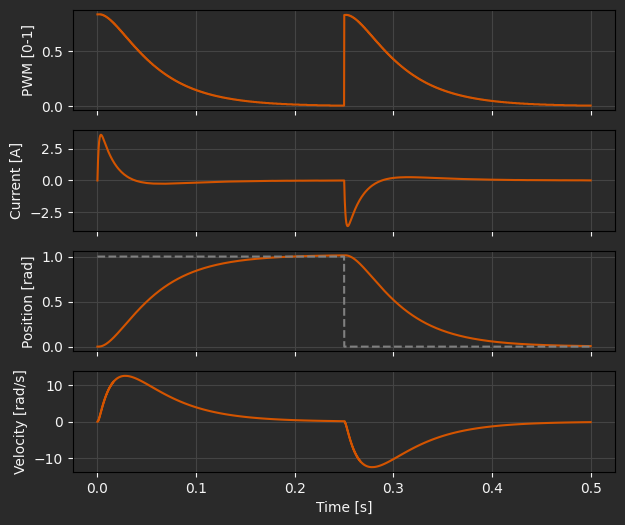

In [ ]:
fig, ax = plt.subplots(4, 1, figsize=(7, 6), sharex=True)
ax[0].plot(ts, pwm_duty)
ax[0].grid()
ax[0].set_ylabel("PWM [0-1]")

ax[1].plot(ts, I_motor)
ax[1].grid()
ax[1].set_ylabel("Current [A]")

ax[2].plot(ts, pos)
ax[2].plot(ts, pos_cmd, linestyle='--', color='gray', label="Command")
ax[2].grid()
ax[2].set_ylabel("Position [rad]")

ax[3].step(ts, vel)
ax[3].grid()
ax[3].set_ylabel("Velocity [rad/s]")

ax[-1].set_xlabel("Time [s]")